In [ ]:
# MEMORY CLEAN
# import gc
# gc.collect()
from IPython import get_ipython
get_ipython().run_line_magic('reset',  '-sf')

In [27]:
# IMPORT
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error

In [28]:
# DATA WRANGLER
path1 = os.path.join("openbiomechanics", "baseball_pitching", "data", "metadata.csv")
meta_data = pd.read_csv(path1)
path2 = os.path.join("openbiomechanics", "baseball_pitching", "data", "full_sig", "forces_moments.csv")
data = pd.read_csv(path2)
path3 = os.path.join("openbiomechanics", "baseball_pitching", "data", "full_sig", "force_plate.csv")
force_data = pd.read_csv(path3)
path4 = os.path.join("openbiomechanics", "baseball_pitching", "data", "poi", "poi_metrics.csv")
poi = pd.read_csv(path4)

# data.groupby('session_pitch').count()
# force_data.groupby('session_pitch').count()
# meta_data.groupby('session_pitch').count()

# Filter by pitch speed, sort by ID num
meta_data = meta_data[meta_data.pitch_speed_mph >= 89].sort_values(by=['session_pitch'], ascending=True)
meta_data['session_pitch'] = meta_data['session_pitch'].str.replace('_', '.', regex=False)
poi['session_pitch'] = poi['session_pitch'].str.replace('_', '.', regex=False)
# Filter session ID by first trial (..._1)
filt_meta_data = meta_data[meta_data['session_pitch'].str.endswith('1')]
constr_data = pd.merge(filt_meta_data[['session_pitch']], data, on='session_pitch', how='left')
constr_poi = pd.merge(filt_meta_data[['session_pitch']], poi, on='session_pitch', how='left')
constr_poi.drop(columns=['session', 'p_throws', 'pitch_type'], inplace=True)

In [29]:
# STATISTICS
mean_age = np.mean(filt_meta_data.age_yrs)
std_age = np.std(filt_meta_data.age_yrs)
mean_height = np.mean(filt_meta_data.session_height_m)
std_height = np.std(filt_meta_data.session_height_m)
mean_mass = np.mean(filt_meta_data.session_mass_kg)
std_mass = np.std(filt_meta_data.session_mass_kg)
# filt_meta_data['playing_level_num'] = filt_meta_data['playing_level'].replace({'college': 1, 'independent': 2, 'milb': 3})
val_counts = filt_meta_data['playing_level'].value_counts()
rel_dist = filt_meta_data['playing_level'].value_counts(normalize=True)
playing_levels = pd.DataFrame({'Playing Level': val_counts.index, 'Amount': val_counts.values, 'Relative Distribution (%)': rel_dist.values * 100})

descriptives_table = {
	'Descriptive': ['Age (years)', 'Height (m)', 'Mass (kg)'],
	'Mean': [mean_age, mean_height, mean_mass],
	'Std Dev': [std_age, std_height, std_mass]
}

# Decide Split for "injury risk" qualification (quartiles may constrain sample too much)
median = np.median(constr_poi.elbow_varus_moment)
varus = pd.DataFrame({
	'varus': (constr_poi.elbow_varus_moment > median).astype(int)
})
# low_varus = constr_poi[constr_poi.elbow_varus_moment <= median]
# high_varus = constr_poi[constr_poi.elbow_varus_moment > median]

In [34]:
# CART
# Regression Tree Features
features = constr_poi.columns.tolist()
remove_features = ['session_pitch', 'pitch_speed_mph']
features = [f for f in features if f not in remove_features]

# Classification
# poi_train_class, poi_test_class, varus_train_class, varus_test_class = train_test_split(constr_poi, varus, test_size=0.2, random_state=42)
# clf = DecisionTreeClassifier(random_state=42)
# clf.fit(poi_train_class, varus_train_class)
# varus_pred = clf.predict(poi_test_class)
# accuracy = accuracy_score(varus_test_class, varus_pred)
# print(f"Classification accuracy: {accuracy:.2f}")

# Regression
poi_train, poi_test, varus_train, varus_test = train_test_split(constr_poi, varus, test_size=0.2, random_state=42)
reg = DecisionTreeRegressor(
	random_state=42,
	max_depth=3,			# Tree complexity
	min_samples_split=5,	# Require > 5 samples to split
	min_samples_leaf=3		# Require > 3 samples per leaf
	) 
reg.fit(poi_train, varus_train)
varus_pred = reg.predict(poi_test)
mse = mean_squared_error(varus_test, varus_pred)
print(f"Regression MSE: {mse:.2f}")

# Cross Validation
cv_scores = cross_val_score(reg, constr_poi[features], varus,
						 cv=21,
						 scoring='neg_mean_squared_error')
print(f"CV MSE: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# CHECK
print(reg.feature_importances_)
from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(poi_train, varus_train)
print(f"Intercept: {lm.intercept_}")
print(f"Coefficients: {dict(zip(poi_train.columns, lm.coef_))}")
print(f"R²: {lm.score(poi_train, varus_train):.4f}")

Regression MSE: 0.60
CV MSE: 0.05 ± 0.21
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Intercept: [-4.65602389]
Coefficients: {'session_pitch': array([-2.67811343e-05,  7.12114199e-06,  5.07623975e-04, -8.35720658e-04,
        9.99598916e-04, -7.50022000e-05, -1.95417657e-05,  2.65063076e-04,
        3.31131161e-05,  1.10113106e-03, -1.21678401e-04,  4.71301276e-04,
        3.68967225e-04, -5.33039610e-04,  1.29631780e-03, -4.77699095e-04,
       -3.76444248e-04,  7.16437460e-06,  1.23536997e-04,  1.17030949e-06,
        9.61253664e-05, -1.32917926e-04, -8.87903691e-05, -4.67806398e-06,
        2.62859647e-04,  2.86475746e-04, -6.55577362e-05, -1.14077999e-04,
        2.42981605e-04, -5.05364317e-05,  1.08942765e-04, -6.59299438e-05,
       -3.83951157e-04,  1.60138228e-04,  6.30202077e-04,  6.01

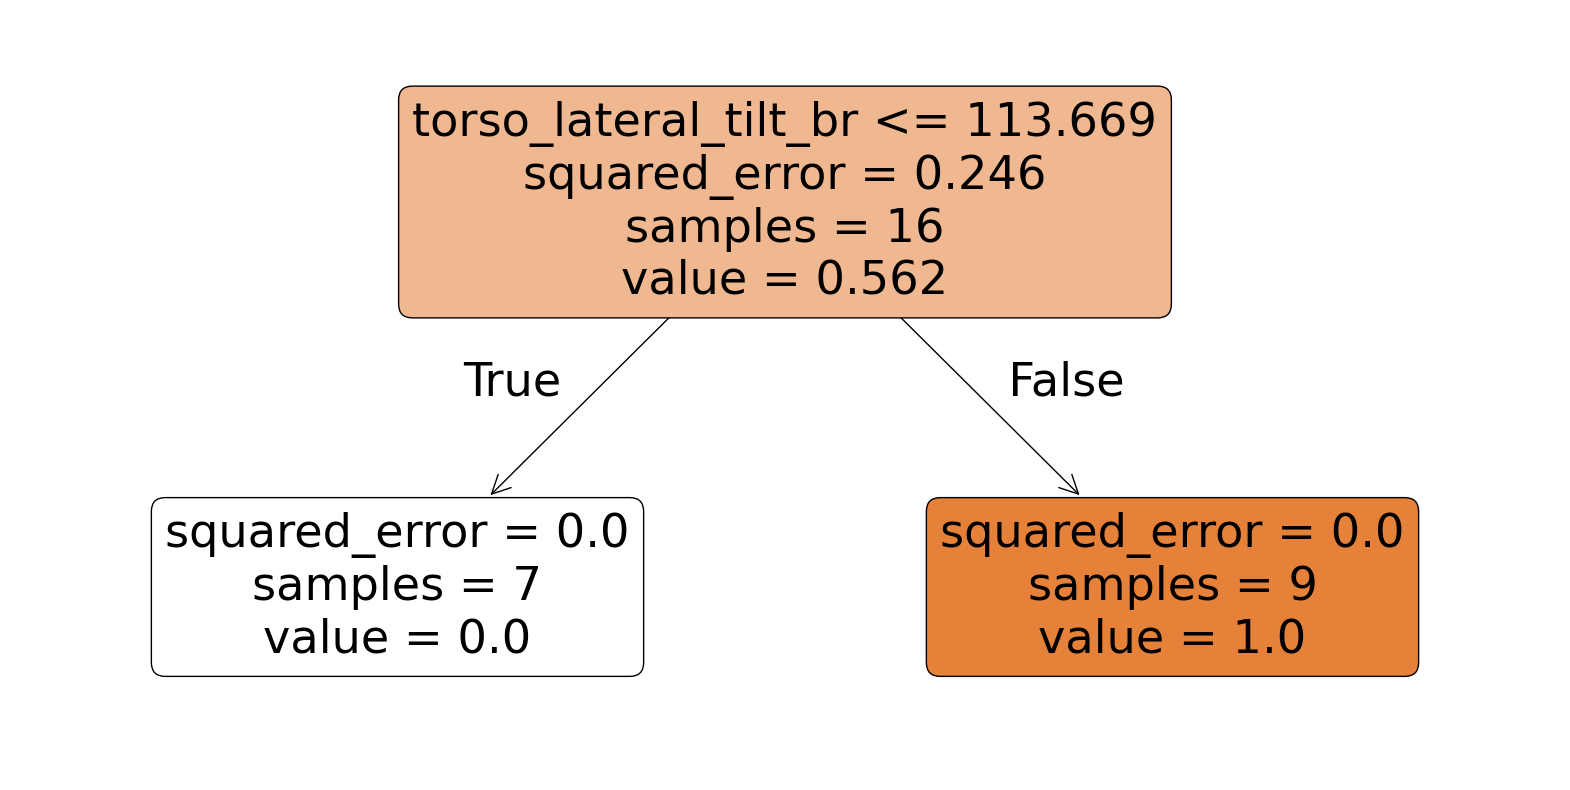

In [35]:
# Visualize
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(reg, feature_names=features, filled=True, rounded=True)
plt.show()

# Comments, first output:
# Max shoulder internal rotation velocity is the largest indicator of elbow varus torque (EVT).
# True Branch: Pitchers with lower MIR velo will have lower EVT. 
# False Branch: Pitchers with  higher MIR velo will have higher EVT.
# New model? Train based on proximal/distal influence (i.e. begin with lead knee kinematics)